# Confirming correct shared version

<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [2]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2019-07-12 23:43:00--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.193
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

100%[======================================>] 23,101      --.-K/s   in 0.001s  

2019-07-12 23:43:00 (16.3 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [3]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [4]:
df.shape

(346, 10)

### Convert to date time object 

In [5]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [6]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [7]:
# notice: installing seaborn might takes a few minutes
#!conda install -c anaconda seaborn -y

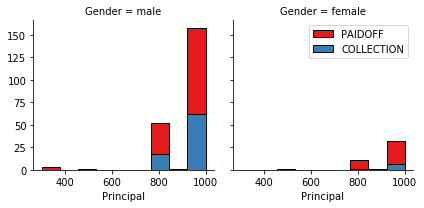

In [8]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

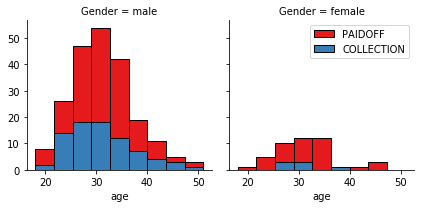

In [9]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

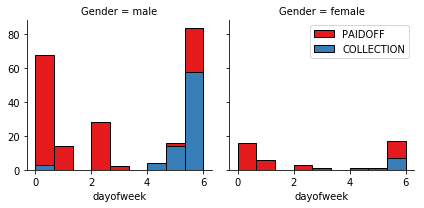

In [10]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [11]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Lets look at gender:

In [12]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [13]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  
#### How about education?

In [14]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding

In [15]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [16]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

Lets defind feature sets, X:

In [17]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?

In [18]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [19]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':


array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

In [20]:
# All records from fourth column onwards
# X = df.iloc[:, 3:].values
Xk = X
# Third column for all records
yk = df.iloc[:, 2].values

# Value of Xk
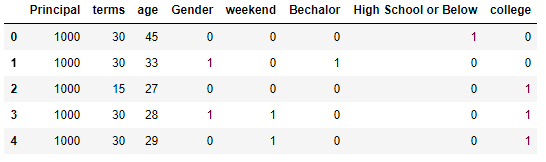


# Value of yk
array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       ...
       'COLLECTION', 'COLLECTION', 'COLLECTION', 'COLLECTION',
       'COLLECTION', 'COLLECTION', 'COLLECTION', 'COLLECTION',
       'COLLECTION', 'COLLECTION', 'COLLECTION'], dtype=object)

In [21]:
# Splits the dataset into 80% train data and 20% test data, random_state fixed to use same data when testing the model
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Xk, yk, test_size=0.20, random_state=4)

In [22]:
# Before making any actual predictions, it is always a good practice to scale the features so that all of them can be uniformly evaluated
# Already done previously
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [23]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics # To check the accuracy

maxK = 25 # Maximum number of K to check accuracy
scores = {}
scores_list = []

for i in range(1, maxK):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    scores[i] = metrics.accuracy_score(y_test, y_pred)
    scores_list.append(metrics.accuracy_score(y_test, y_pred))

Text(0, 0.5, 'Accuracy')

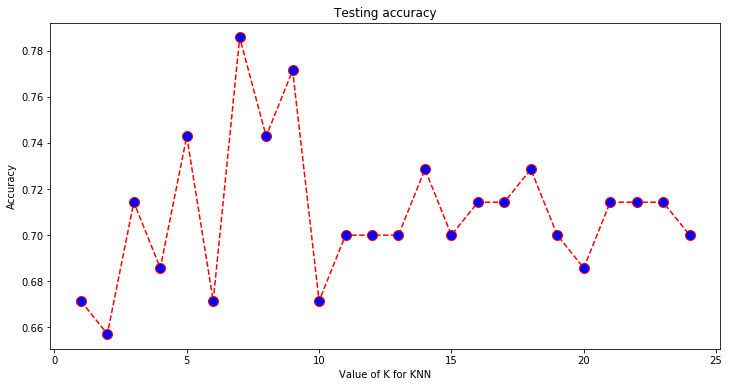

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt

# Plot K and test accuracy relationship
plt.figure(figsize=(12, 6))
plt.title('Testing accuracy')
plt.plot(range(1,maxK), scores_list, color='red', linestyle='dashed', marker='o', markerfacecolor='blue', markersize=10)
plt.xlabel('Value of K for KNN')
plt.ylabel('Accuracy')

# =================================================
# Solution
## K = 7 is the best K to build the model with the best accuracy (78%)
# =================================================

In [25]:
# Retrain the model with all the available data using found K
knn_model = KNeighborsClassifier(n_neighbors=7)
knn_model.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=7, p=2,
           weights='uniform')

In [201]:
# Making predictions on unseen data
x_new = [[1000, 15, 29, 1, 0, 0, 0, 1],
         [1000, 15, 29, 0, 0, 0, 0, 1],
         [1000, 15, 29, 1, 1, 0, 0, 1],
         [1000, 15, 29, 0, 1, 0, 0, 1]]
x_new = X
scaler.fit(x_new)
x_new = scaler.transform(x_new)
y_new_pred = knn.predict(x_new)

grid = pd.DataFrame(data=y_new_pred)
grid.columns = ['loan_status']
grid.head()
print('Original count: ' + str(df['loan_status'].value_counts()))
print('Predictions: ' + str(grid['loan_status'].value_counts()))


Original count: PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64
Predictions: PAIDOFF       314
COLLECTION     32
Name: loan_status, dtype: int64


## From this point onwards is just some code to check the mean of the error to confirm the K found is correct

In [162]:
knn = KNeighborsClassifier(7)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
    
# Confusion matrix, precision, recall and f1 score are the most commonly used metrics for evaluating an algorithm, classification report method can be used to calculate these metrics.
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[ 6  9]
 [ 6 49]]
              precision    recall  f1-score   support

  COLLECTION       0.50      0.40      0.44        15
     PAIDOFF       0.84      0.89      0.87        55

   micro avg       0.79      0.79      0.79        70
   macro avg       0.67      0.65      0.66        70
weighted avg       0.77      0.79      0.78        70



In [163]:
# Calculate the mean of error for all the predicted values where K ranges from 1 and maxK
error = []

for i in range(1, maxK):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    error.append(np.mean(pred_i != y_test))

Text(0, 0.5, 'Mean Error')

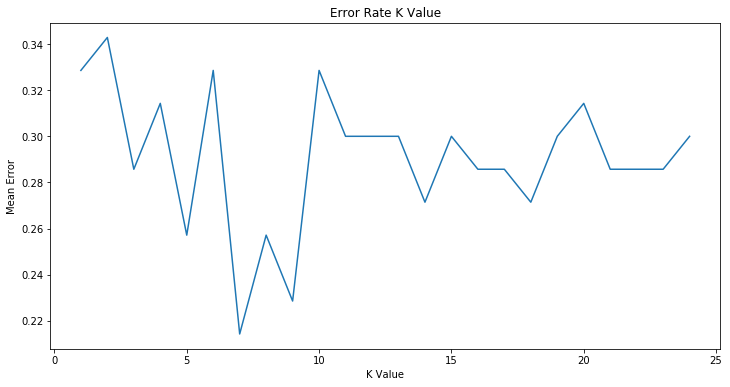

In [164]:
# Plot the error values against K values to identify the best K value for the model
plt.figure(figsize=(12, 6))
plt.plot(range(1, maxK), error)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')

# Decision Tree

In [166]:
from sklearn.tree import DecisionTreeClassifier
loanTree_model = DecisionTreeClassifier(criterion="entropy", max_depth = 4)

loanTree_model.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [167]:
# Start predictions
y_pred = loanTree_model.predict(X_test)

# To compare actual values against predicted ones
print (y_pred [0:5])
print (y_test [0:5])

['COLLECTION' 'COLLECTION' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']
['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']


In [169]:
# Check model's accuracy
from sklearn import metrics
import matplotlib.pyplot as plt
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_test, y_pred))

DecisionTrees's Accuracy:  0.6142857142857143


# =================================================
# Solution
## Model's accuracy:  61.42%
# =================================================

In [172]:
# Install needed modules to show tree
!conda install -c conda-forge pydotplus -y

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - pydotplus


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2019.6.16          |           py36_0         148 KB  conda-forge
    pydotplus-2.0.2            |             py_2          23 KB  conda-forge
    ca-certificates-2019.6.16  |       hecc5488_0         145 KB  conda-forge
    openssl-1.1.1c             |       h516909a_0         2.1 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.4 MB

The following NEW packages will be INSTALLED:

    pydotplus:       2.0.2-py_2        conda-forge

The following packages will be UPDATED:

    ca-certificates: 2019.5.15-0                   --> 2019.6.16-hecc5488_0 conda-forge
    certifi:         2019.6.16-py36_0       

In [175]:
# Visualization
from sklearn.externals.six import StringIO
import pydotplus
import matplotlib.image as mpimg
from sklearn import tree
%matplotlib inline 

In [176]:
dot_data = StringIO()
filename = "loantree.png"
featureNames = Xk.columns[0:8]
targetNames = df["loan_status"].unique().tolist()
out=tree.export_graphviz(loanTree_model,feature_names=featureNames, out_file=dot_data, class_names= np.unique(y_train), filled=True,  special_characters=True,rotate=False)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png(filename)
img = mpimg.imread(filename)
plt.figure(figsize=(100, 200))
plt.imshow(img,interpolation='nearest')

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

# Support Vector Machine

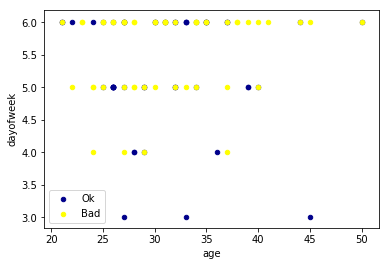

In [174]:
# Import needed libraries and plot some data
import scipy.optimize as opt
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix
import itertools
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_similarity_score

ax = df[df['loan_status'] == 'PAIDOFF'][0:50].plot(kind='scatter', x='age', y='dayofweek', color='DarkBlue', label='Ok');
df[df['loan_status'] == 'COLLECTION'][0:50].plot(kind='scatter', x='age', y='dayofweek', color='Yellow', label='Bad', ax=ax);
plt.show()

In [231]:
# Data preprocessing
Xsvm = np.asarray(Feature)
ysvm = df.iloc[:, 2].map({'PAIDOFF': 1, 'COLLECTION': 0})
print('Features:')
print(Xsvm[0:5])
print('Values to predict:')
print(ysvm[0:5])

Features:
[[1000   30   45    0    0    0    1    0]
 [1000   30   33    1    0    1    0    0]
 [1000   15   27    0    0    0    0    1]
 [1000   30   28    1    1    0    0    1]
 [1000   30   29    0    1    0    0    1]]
Values to predict:
0    1
1    1
2    1
3    1
4    1
Name: loan_status, dtype: int64


In [177]:
svm_model = svm.SVC(kernel='rbf', gamma='auto')
svm_model.fit(X_train, y_train) # Train the model
yhat = svm_model.predict(X_test) # Test the model
yhat [0:5]

array(['COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

In [178]:
# Model's evaluation
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [179]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=[1,0])
np.set_printoptions(precision=2)

print (classification_report(y_test, yhat))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['PAIDOFF(1)','COLLECTION(0)'],normalize= False,  title='Confusion matrix')

ValueError: At least one label specified must be in y_true

In [180]:
print("Avg F1-score: %.4f" % f1_score(y_test, yhat, average='weighted'))
print("Jaccard score: %.4f" % jaccard_similarity_score(y_test, yhat))

Avg F1-score: 0.7276
Jaccard score: 0.7429


# =================================================
# Solution
## Avg F1-score: 0.7276
## Jaccard score: 0.7429
# =================================================

# Logistic Regression

In [183]:
# Regularization is a technique used to solve the overfitting problem in machine learning models. C parameter indicates inverse of regularization strength which must be a positive float. Smaller values specify stronger regularization.
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
LR_model = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)

In [184]:
# Predicting
yhat = LR_model.predict(X_test)
#yhat

# predict_proba returns estimates for all classes, ordered by the label of classes. So, the first column is the probability of class 1, P(Y=1|X), and second column is probability of class 0, P(Y=0|X)
yhat_prob = LR_model.predict_proba(X_test)
#yhat_prob

# Model's evaluation using Jaccard
from sklearn.metrics import jaccard_similarity_score
print(jaccard_similarity_score(y_test, yhat))

# Model's evaluation using F1 score
print("Avg F1-score: %.4f" % f1_score(y_test, yhat, average='weighted'))

# Show confusion matrix and classification report
print(confusion_matrix(y_test, yhat))
print (classification_report(y_test, yhat))
# Confusion matrix can't be plotted because the value for COLLECT IS 0 of 23

# Show logarythmic loss
from sklearn.metrics import log_loss
print("LogLoss (liblinear) : : %.2f" % log_loss(y_test, yhat_prob))

# Use different __solver__ and __regularization__ values
LR2_model = LogisticRegression(C=0.01, solver='sag').fit(X_train,y_train)
yhat_prob2 = LR2.predict_proba(X_test)
print ("LogLoss (sag): : %.2f" % log_loss(y_test, yhat_prob2))

0.7142857142857143
Avg F1-score: 0.6860
[[ 2 13]
 [ 7 48]]
              precision    recall  f1-score   support

  COLLECTION       0.22      0.13      0.17        15
     PAIDOFF       0.79      0.87      0.83        55

   micro avg       0.71      0.71      0.71        70
   macro avg       0.50      0.50      0.50        70
weighted avg       0.67      0.71      0.69        70

LogLoss (liblinear) : : 0.58
LogLoss (sag): : 0.69


# =================================================
# Solution
## Avg F1-score: 0.6860
## Jaccard score: 0.7142
# =================================================

# Model Evaluation using Test set

In [56]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:

In [57]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2019-07-12 20:00:00--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.193
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

100%[======================================>] 3,642       --.-K/s   in 0s      

2019-07-12 20:00:00 (541 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation 

In [84]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [85]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics # To check the accuracy

# Preprocessing
df_testk = test_df
df_testk['due_date'] = pd.to_datetime(df_testk['due_date'])
df_testk['effective_date'] = pd.to_datetime(df_testk['effective_date'])
df_testk['dayofweek'] = df_testk['effective_date'].dt.dayofweek
df_testk['weekend'] = df_testk['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df_testk['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)

X_testk = df_testk[['Principal','terms','age','Gender','weekend']]
X_testk = pd.concat([X_testk,pd.get_dummies(df_testk['education'])], axis=1)
X_testk.drop(['Master or Above'], axis = 1,inplace=True)

y_testk = df_testk['loan_status'].values

# Data Standardization
X_testk = preprocessing.StandardScaler().fit(X_testk).transform(X_testk)

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:19: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.


# KNN

In [165]:
# Start predictions
y_testpred = knn_model.predict(X_testk)

# Model's evaluation using Accuracy score
print("Accuracy: %.4f" % metrics.accuracy_score(y_testk, y_testpred))

# Model's evaluation using Jaccard
print('Jaccard %.4f' % jaccard_similarity_score(y_testk, y_testpred))

# Model's evaluation using F1 score
print("Avg F1-score: %.4f" % f1_score(y_testk, y_testpred, average='weighted'))

Accuracy: 0.6667
Jaccard 0.6667
Avg F1-score: 0.6328


# Decision Tree

In [173]:
# Start predictions
y_testpred = loanTree_model.predict(X_testk)

# Model's evaluation using Accuracy score
print("Accuracy: %.4f" % metrics.accuracy_score(y_testk, y_testpred))

# Model's evaluation using Jaccard
print('Jaccard %.4f' % jaccard_similarity_score(y_testk, y_testpred))

# Model's evaluation using F1 score
print("Avg F1-score: %.4f" % f1_score(y_testk, y_testpred, average='weighted'))

Accuracy: 0.7222
Jaccard 0.7222
Avg F1-score: 0.7367


# SVM

In [181]:
# Start predictions
y_testpred = svm_model.predict(X_testk) # Test the model

# Model's evaluation using Accuracy score
print("Accuracy: %.4f" % metrics.accuracy_score(y_testk, y_testpred))

# Model's evaluation using Jaccard
print('Jaccard %.4f' % jaccard_similarity_score(y_testk, y_testpred))

# Model's evaluation using F1 score
print("Avg F1-score: %.4f" % f1_score(y_testk, y_testpred, average='weighted'))

Accuracy: 0.7963
Jaccard 0.7963
Avg F1-score: 0.7584


# Logistic Regression

In [185]:
# Start predictions
y_testpred = LR_model.predict(X_testk)
y_testpred_prob = LR_model.predict_proba(X_testk)

# Model's evaluation using Accuracy score
print("Accuracy: %.4f" % metrics.accuracy_score(y_testk, y_testpred))

# Model's evaluation using Jaccard
print('Jaccard %.4f' % jaccard_similarity_score(y_testk, y_testpred))

# Model's evaluation using F1 score
print("Avg F1-score: %.4f" % f1_score(y_testk, y_testpred, average='weighted'))

# Model's evaluation using Log loss
print("LogLoss (liblinear) : : %.2f" % log_loss(y_testpred, y_testpred_prob))

Accuracy: 0.7593
Jaccard 0.7593
Avg F1-score: 0.6718
LogLoss (liblinear) : : 0.52


# Report
You should be able to report the accuracy of the built model using different evaluation metrics:

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | 66.67   | 63.28    | NA      |
| Decision Tree      | 72.22   | 73.67    | NA      |
| SVM                | 79.63   | 75.84    | NA      |
| LogisticRegression | 75.93   | 67.18    | 52      |

<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

<p>Copyright &copy; 2018 <a href="https://cocl.us/DX0108EN_CC">Cognitive Class</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.</p>